In [1]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.7 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ReduceLROnPlateau
import torch.nn.functional as F
from monai.networks.nets import UNet
from monai.metrics import MeanIoU
from monai.losses import DiceLoss, DiceCELoss, GeneralizedDiceFocalLoss
# from monai.transforms import (
#     Compose,
#     ScaleIntensityd,
#     RandFlipd,
#     RandRotate90d,
#     RandShiftIntensityd,
#     RandGaussianNoised,
#     RandSpatialCropd,
#     RandAffined,
#     EnsureTyped,
# )

from monai.transforms import (
    Compose,
    ScaleIntensityd,
    NormalizeIntensityd,
    RandFlipd,
    Rand3DElasticd,
    RandGridDistortiond,
    RandGaussianSmoothd,
    RandScaleIntensityd,
    RandHistogramShiftd,
    RandSpatialCropd,
    EnsureTyped
)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from skimage.transform import resize
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate

import nibabel as nib
from sklearn.preprocessing import MinMaxScaler
import albumentations as A
import pandas as pd
import os
import glob
import numpy as np
from tqdm import tqdm
import shutil
import cv2

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Visualization And Analysis

In [3]:
root_path = "/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG/"

In [4]:
name = root_path + "BraTS19_2013_10_1/BraTS19_2013_10_1_seg.nii"

print(name)

/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_seg.nii


In [5]:
test_image_flair = nib.load(root_path + "BraTS19_2013_10_1/BraTS19_2013_10_1_flair.nii").get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)

Shape:  (240, 240, 155)
Dtype:  float64


In [6]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1273.0


In [7]:
scaler = MinMaxScaler()

In [8]:
# Scale the test_image_flair array and then reshape it back to its original dimensions.
# This ensures the data is normalized/standardized for model input without altering its spatial structure.
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [9]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1.0


In [10]:
# rescaling t1
test_image_t1 = nib.load(root_path + 'BraTS19_2013_10_1/BraTS19_2013_10_1_t1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load(root_path + 'BraTS19_2013_10_1/BraTS19_2013_10_1_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load(root_path + 'BraTS19_2013_10_1/BraTS19_2013_10_1_t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# we will not rescale the mask
test_image_seg = nib.load(root_path + 'BraTS19_2013_10_1/BraTS19_2013_10_1_seg.nii').get_fdata()

Slice Number: 95


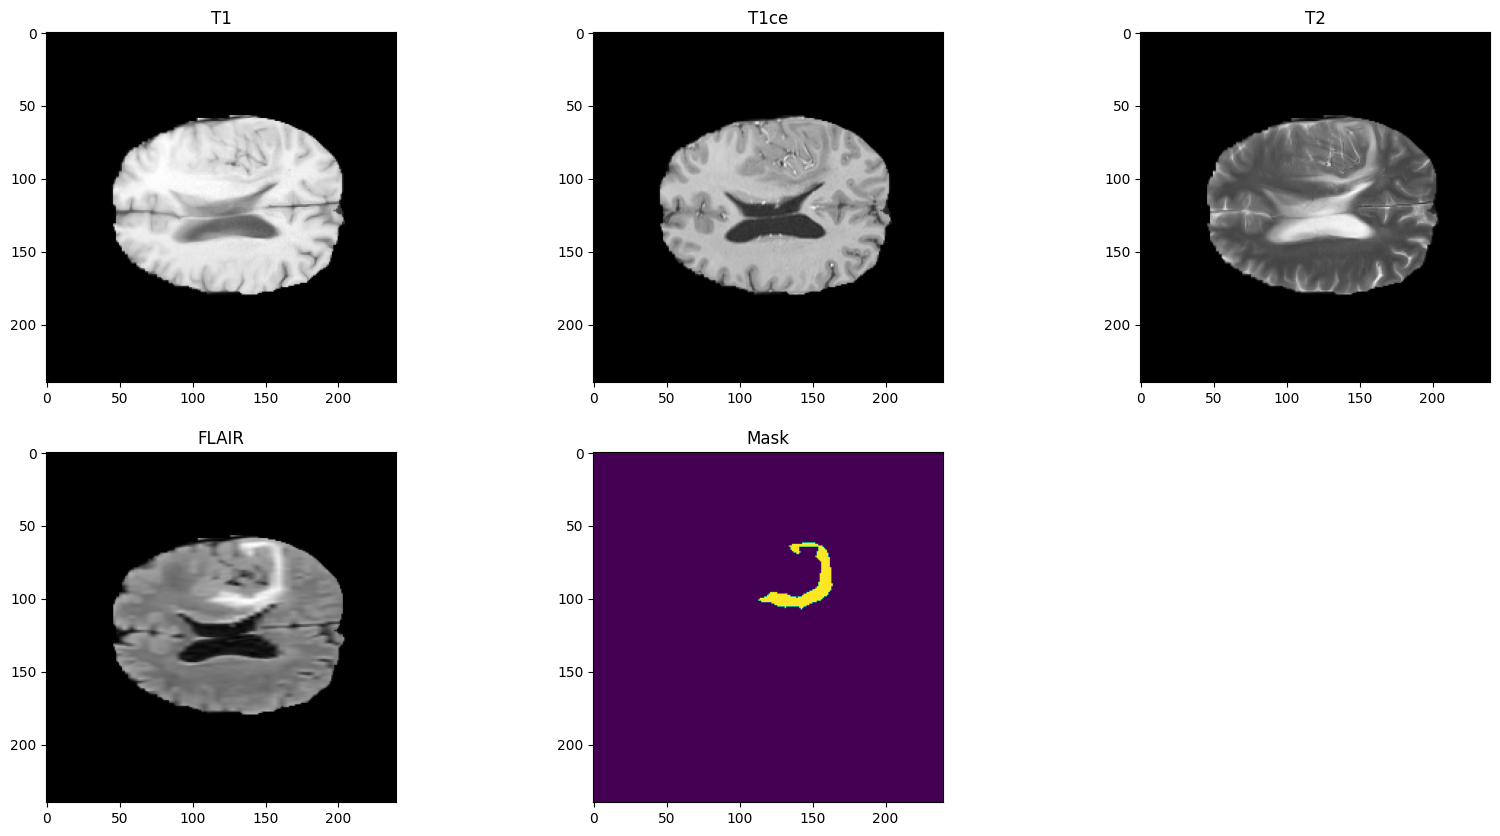

In [11]:
slice = 95

print("Slice Number: " + str(slice))

plt.figure(figsize=(20, 10))

# T1
plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1ce')

# T2
plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Mask')
plt.show()

In [12]:
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


Slice number: 95


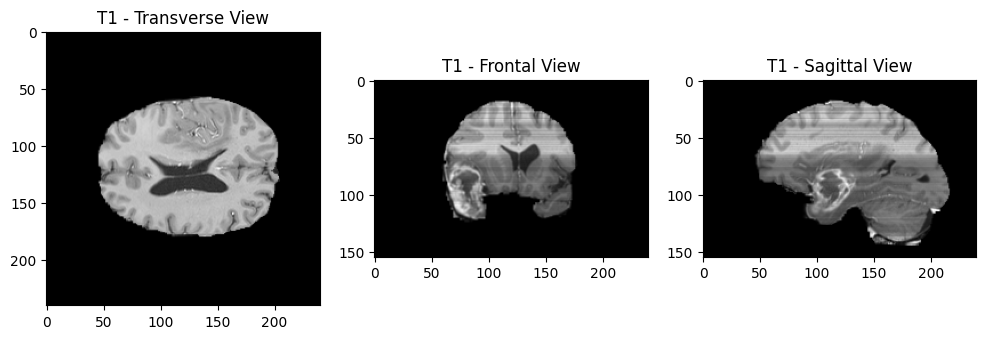

In [13]:
slice = 95

print("Slice number: " + str(slice))

plt.figure(figsize=(12, 8))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze

plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1 - Transverse View')

plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,slice,:], 90, resize=True), cmap='gray')
plt.title('T1 - Frontal View')

plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.show()

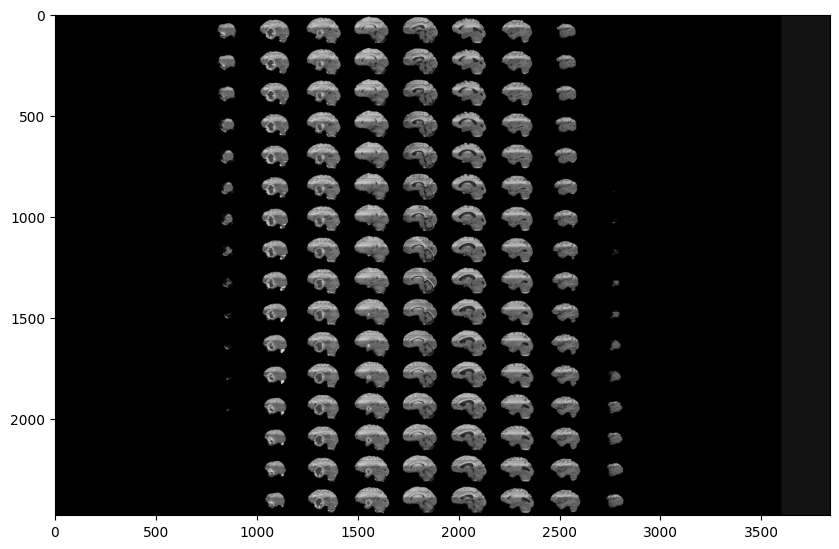

In [14]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

# montage allows us to concatenate multiple images of the same size horizontally and vertically
plt.imshow(rotate(montage(test_image_t1ce[:,:,:]), 90, resize=True), cmap ='gray');

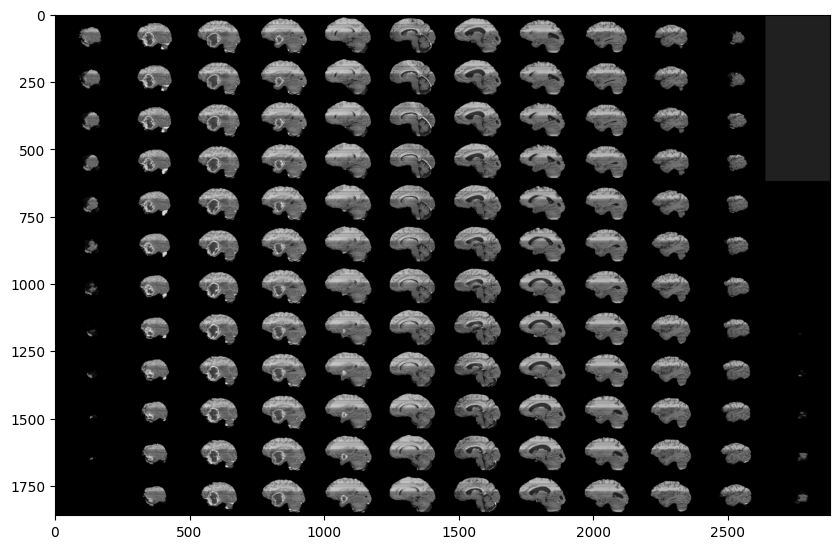

In [15]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_t1ce[50:-50,:,:]), 90, resize=True), cmap ='gray');

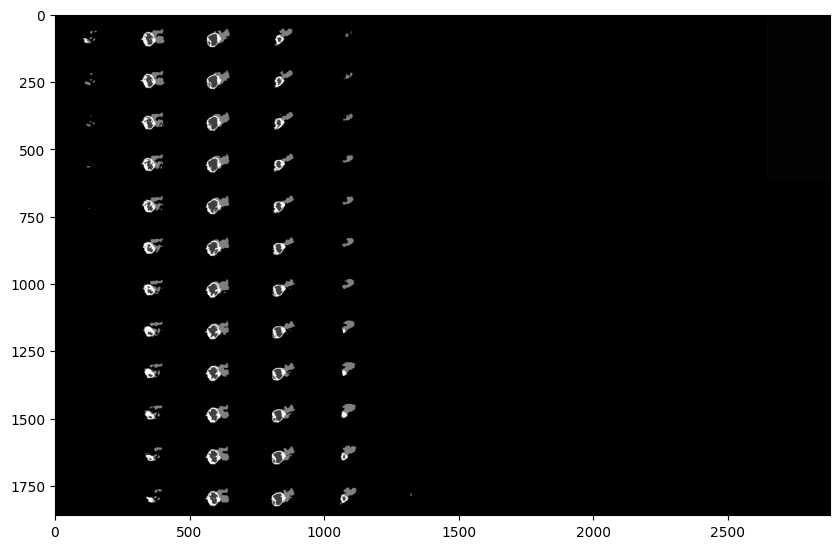

In [16]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_seg[50:-50,:,:]), 90, resize=True), cmap ='gray');

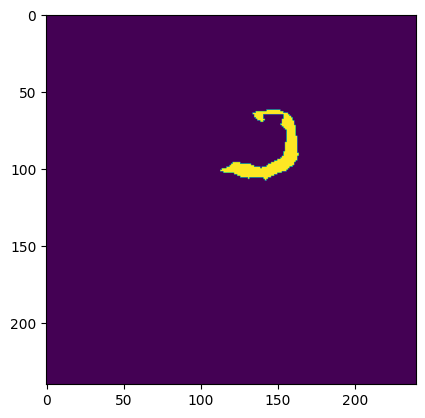

In [17]:
plt.imshow(test_image_seg[:,:,95])

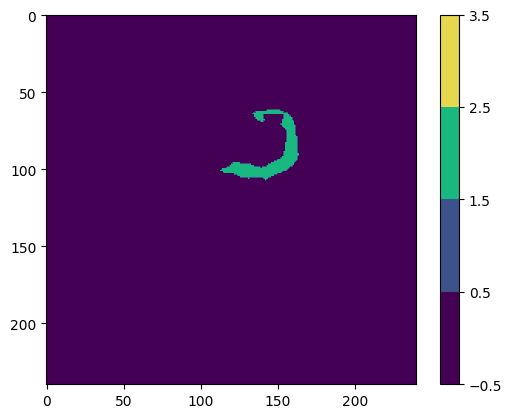

In [18]:
# Plotting the segmantation
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# plotting the 95th slice
plt.imshow(test_image_seg[:,:,95], cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

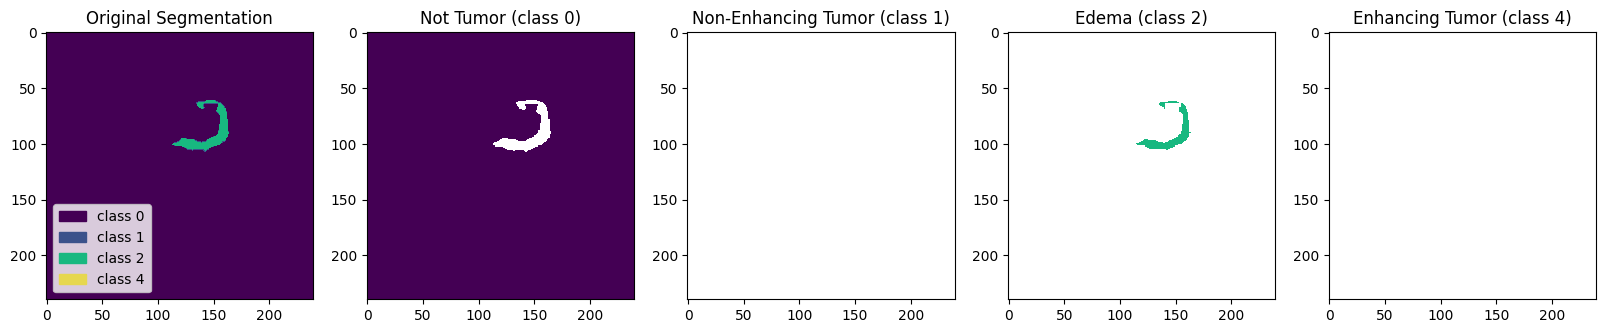

In [19]:
# Isolation of class 0
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(test_image_seg[:,:, slice], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend, loc='lower left')

ax[1].imshow(seg_0[:,:, slice], cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')

ax[2].imshow(seg_1[:,:, slice], cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing Tumor (class 1)')

ax[3].imshow(seg_2[:,:, slice], cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')

ax[4].imshow(seg_4[:,:, slice], cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')

plt.show()

In [20]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE',
    2 : 'EDEMA',
    3 : 'ENHANCING' # 4
}

VOLUME_SLICES = 128
VOLUME_START_AT = 22
IMG_SIZE = 128

In [21]:
class BratsDataset(Dataset):
    def __init__(self, root="/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training", is_train=True, dim=(IMG_SIZE, IMG_SIZE), n_channels=4, 
                 volume_slices=VOLUME_SLICES, volume_start_at=22, transform=None):
        self.dim = dim
        self.n_channels = n_channels
        self.volume_slices = volume_slices
        self.volume_start_at = volume_start_at
        self.transform = transform
        
        if is_train:
            self.root = os.path.join(root, 'HGG')
        else:
            self.root = os.path.join(root, 'LGG')

        self.list_paths = [
            folder for folder in os.listdir(self.root)
            if not folder.endswith(".csv") and os.path.exists(os.path.join(self.root, folder, f"{folder}_seg.nii"))
        ]
        
    def __len__(self):
        return len(self.list_paths)

    def __getitem__(self, index):
        X = np.zeros((self.n_channels, self.volume_slices, *self.dim))
        y = np.zeros((self.volume_slices, *self.dim))
    
        case_id = self.list_paths[index]
        case_path = os.path.join(self.root, case_id)
    
        flair = nib.load(os.path.join(case_path, f'{case_id}_flair.nii')).get_fdata()
        t1ce = nib.load(os.path.join(case_path, f'{case_id}_t1ce.nii')).get_fdata()
        t1 = nib.load(os.path.join(case_path, f'{case_id}_t1.nii')).get_fdata()
        t2 = nib.load(os.path.join(case_path, f'{case_id}_t2.nii')).get_fdata()
        seg = nib.load(os.path.join(case_path, f'{case_id}_seg.nii')).get_fdata()

        # T1, T2, FLAIR, T1c
        for j in range(self.volume_slices):
            X[0, j, :, :] = cv2.resize(t1[:, :, j + self.volume_start_at], self.dim)
            X[1, j, :, :] = cv2.resize(t2[:, :, j + self.volume_start_at], self.dim)
            X[2, j, :, :] = cv2.resize(flair[:, :, j + self.volume_start_at], self.dim)
            X[3, j, :, :] = cv2.resize(t1ce[:, :, j + self.volume_start_at], self.dim)
            y[j, :, :] = cv2.resize(seg[:, :, j + self.volume_start_at], self.dim)
    
        y[y == 4] = 3  # 4 -> 3

        # Chuyển đổi sang tensor
        X = torch.tensor(X / np.max(X), dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)

        # Áp dụng augmentation
        if self.transform:
            transformed = self.transform({"image": X, "label": y})
            X, y = transformed["image"], transformed["label"]
        
        # Chuyển nhãn thành one-hot
        y = y.long()
        mask = F.one_hot(y, num_classes=4).permute(3, 0, 1, 2)  # [C, D, H, W]
        
        return X, mask

In [22]:
# # Pipeline augmentation
# train_transforms = Compose([
#     ScaleIntensityd(keys="image"),  # Chuẩn hóa cường độ pixel
#     RandFlipd(keys=["image", "label"], spatial_axis=[0], prob=0.5),  # Lật ngẫu nhiên
#     RandRotate90d(keys=["image", "label"], prob=0.5),  # Xoay 90 độ ngẫu nhiên
#     RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),  # Thay đổi cường độ ngẫu nhiên
#     RandGaussianNoised(keys="image", prob=0.2),  # Thêm nhiễu Gaussian
#     # RandAffined(
#     #     keys=["image", "label"],
#     #     rotate_range=(0.1, 0.1, 0.1),  # Biến đổi xoay
#     #     scale_range=(0.1, 0.1, 0.1),  # Phóng to/thu nhỏ
#     #     spatial_size=(128, 128, 128),
#     #     prob=0.5
#     # ),
#     RandSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 128], random_size=False),  # Cắt ngẫu nhiên vùng 3D
#     EnsureTyped(keys=["image", "label"]),  # Đảm bảo kiểu dữ liệu
# ])

# # Pipeline cho validation không cần augmentation
# val_transforms = Compose([
#     ScaleIntensityd(keys="image"),  # Chuẩn hóa cường độ pixel
#     NormalizeIntensityd(keys="image", nonzero=False, channel_wise=True),  # Chuẩn hóa tất cả các giá trị pixel, bao gồm cả nền
#     EnsureTyped(keys=["image", "label"]),  # Đảm bảo kiểu dữ liệu
# ])


In [23]:
# Pipeline augmentation cho train
train_transforms = Compose([
    ScaleIntensityd(keys="image"),  # Chuẩn hóa cường độ pixel
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),  # Chuẩn hóa từng kênh
    RandFlipd(keys=["image", "label"], spatial_axis=[0], prob=0.5),  # Lật theo trục X
    RandFlipd(keys=["image", "label"], spatial_axis=[1], prob=0.5),  # Lật theo trục Y
    # Rand3DElasticd(keys=["image", "label"], sigma_range=(5, 8), magnitude_range=(1, 2), prob=0.3),  # Biến dạng đàn hồi 3D
    # RandGridDistortiond(keys=["image", "label"], distort_limit=(-0.03, 0.03), prob=0.2),  # Biến dạng lưới
    RandGaussianSmoothd(keys="image", sigma_x=(0.5, 1.5), sigma_y=(0.5, 1.5), sigma_z=(0.5, 1.5), prob=0.2),  # Làm mịn Gaussian
    RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),  # Thay đổi cường độ ngẫu nhiên
    RandHistogramShiftd(keys="image", num_control_points=5, prob=0.3),  # Thay đổi histogram
    RandSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 128], random_size=False),  # Cắt vùng 3D
    EnsureTyped(keys=["image", "label"]),  # Đảm bảo kiểu dữ liệu
])

# Pipeline cho validation không cần augmentation
val_transforms = Compose([
    ScaleIntensityd(keys="image"),  # Chuẩn hóa cường độ pixel
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),  # Chuẩn hóa từng kênh
    EnsureTyped(keys=["image", "label"]),  # Đảm bảo kiểu dữ liệu
])

In [24]:
train_dataset = BratsDataset(transform=train_transforms)
image, mask = train_dataset[20]
print(image.shape)
mask.shape

torch.Size([4, 128, 128, 128])


torch.Size([4, 128, 128, 128])

In [25]:
# class BrastDataset(Dataset):
#     def __init__(self, root="/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training", is_train=True, is_resize=True, transform=None, unnormalize_flag=False):
#         if is_train:
#             self.root = os.path.join(root, 'HGG')
#         else:
#             self.root = os.path.join(root, 'LGG')

#         self.ls = [
#             folder for folder in os.listdir(self.root)
#             if not folder.endswith(".csv") and os.path.exists(os.path.join(self.root, folder, f"{folder}_seg.nii"))
#         ]
        
#         self.is_train = is_train
#         self.is_resize = is_resize
#         # self.transform = transform
#         self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
#         self.unnormalize_flag = unnormalize_flag

#     def __len__(self):
#         return len(self.ls)

#     def __getitem__(self, idx):
#         paths = self.ls[idx]
#         images = []
#         min_values = []
#         max_values = []

#         for data_type in self.data_types:
#             image = self.load(f"{os.path.join(self.root, paths)}/{paths}{data_type}")
#             if self.is_resize:
#                 image = self.resize(image)
            
#             image, _min, _max = self.normalize(image)
#             min_values.append(_min)
#             max_values.append(_max)
#             images.append(torch.tensor(image, dtype=torch.float32))

#         images = torch.stack(images)

#         path_mask = f"{os.path.join(self.root, paths)}/{paths}_seg.nii"
#         mask = self.load(path_mask)
#         if self.is_resize:
#             mask = self.resize(mask)
                
#         mask = self.preprocess_mask(mask)
        
#         if self.unnormalize_flag:
#             images = self.unnormalize(images, min_values, max_values)
                
#         return images, mask

#     def load(self, path):
#         data = nib.load(path)
#         data = np.asarray(data.dataobj)
#         return data

#     def normalize(self, data):
#         _min = np.min(data)
#         _max = np.max(data)
#         normalized_data = (data - _min) / (_max - _min)
#         return normalized_data, _min, _max

#     def unnormalize(self, normalized_data, min_values, max_values):
#         unnormalized_images = []
#         for i in range(len(normalized_data)):
#             unnormalized_image = normalized_data[i] * (max_values[i] - min_values[i]) + min_values[i]
#             unnormalized_images.append(unnormalized_image)
#         return torch.tensor(np.stack(unnormalized_images), dtype=torch.float32)

#     def resize(self, data):
#         data = resize(data, (128, 128, 128), preserve_range=True)
#         return data

#     def preprocess_mask(self, mask):
#         mask_WT = mask.copy()
#         mask_WT[mask_WT == 1] = 1
#         mask_WT[mask_WT == 2] = 1
#         mask_WT[mask_WT == 4] = 1

#         mask_TC = mask.copy()
#         mask_TC[mask_TC == 1] = 1
#         mask_TC[mask_TC == 2] = 0
#         mask_TC[mask_TC == 4] = 1

#         mask_ET = mask.copy()
#         mask_ET[mask_ET == 1] = 0
#         mask_ET[mask_ET == 2] = 0
#         mask_ET[mask_ET == 4] = 1

#         mask_WT = torch.tensor(mask_WT, dtype=torch.float)
#         mask_TC = torch.tensor(mask_TC, dtype=torch.float)
#         mask_ET = torch.tensor(mask_ET, dtype=torch.float)

#         mask = torch.stack([mask_WT, mask_TC, mask_ET], axis=0)
#         return mask

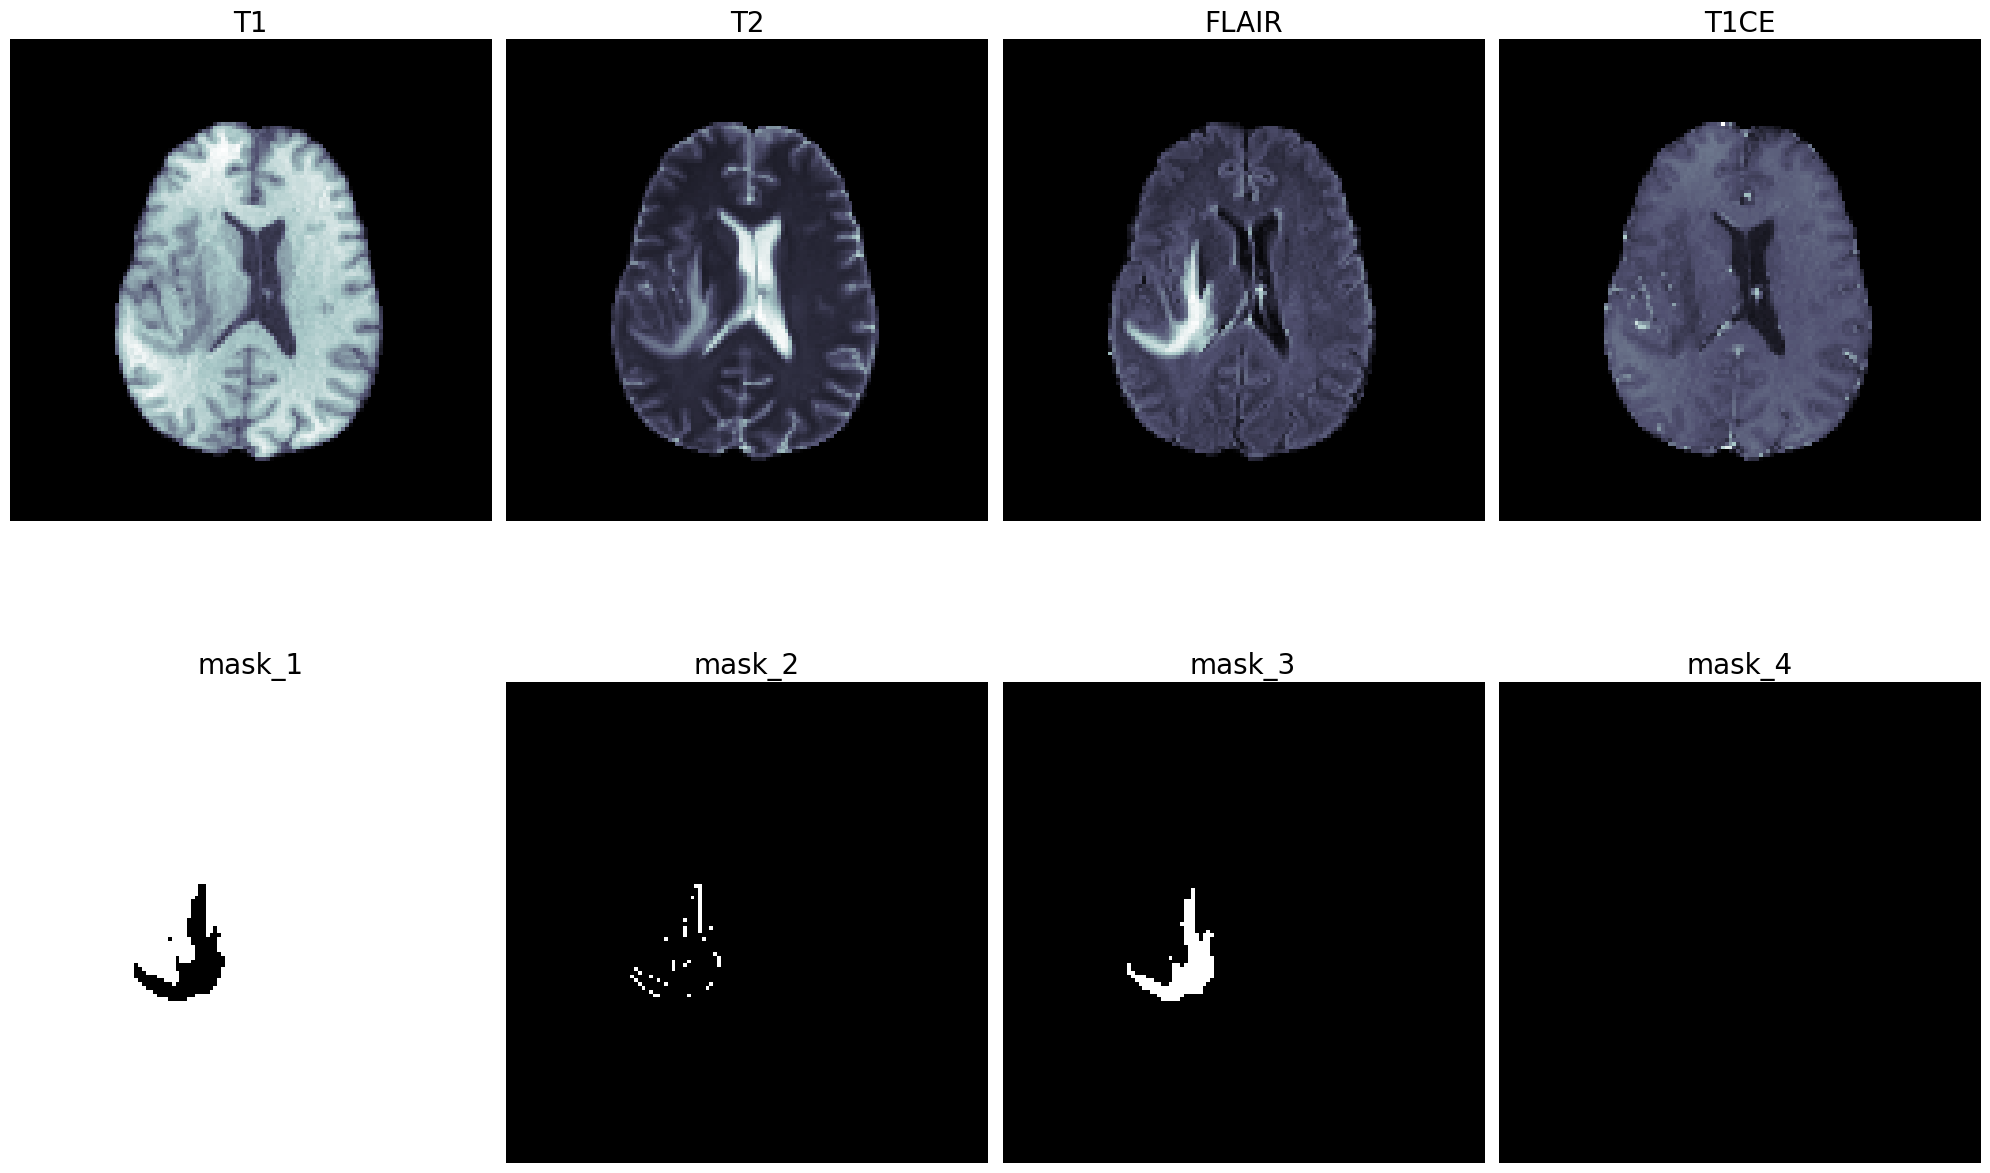

In [26]:
train_dataset = BratsDataset()
images, masks = train_dataset[20]

# plt.subplot(1, 2, 1)
# plt.imshow(images[0].permute(2, 1, 0)[:, :, 65], cmap='bone')
# plt.subplot(1, 2, 2)
# plt.imshow(mask[0].permute(2, 1, 0)[:, :, 65], cmap='bone')
# plt.show()

    
fig = plt.figure(figsize=(20, 20))
for j in range(4):
    ax = fig.add_subplot(1 * 3, 4, 0 * 12 + j + 1)
    ax.imshow(images[j].permute(2, 1, 0)[:, :, 65], cmap='bone')
    ax.axis('off')
    titles = ["T1", "T2", "FLAIR", "T1CE"]
    ax.set_title(titles[j], fontsize=20)

    ax1 = fig.add_subplot(1 * 3, 4, 0 * 12 + 4 + j + 1)
    ax1.imshow(masks[j].permute(2, 1, 0)[:, :, 65], cmap='bone')
    ax1.axis('off')
    titles = ["mask_1", "mask_2", "mask_3", "mask_4"]
    ax1.set_title(titles[j], fontsize=20)

plt.tight_layout()
plt.show()

## AverageMeter

In [27]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n = 1):
        self.val += val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Show Loss

In [28]:
def plot_segmentation_metrics(train_loss, val_loss, train_mean_iou=None, val_mean_iou=None, 
                              train_dice_score=None, val_dice_score=None):
    """
    Plot training and validation metrics (loss, mean IoU, Dice score) over epochs.

    Args:
    - train_loss (list): List of training loss values over epochs.
    - val_loss (list): List of validation loss values over epochs.
    - train_mean_iou (list, optional): List of training mean IoU values over epochs.
    - val_mean_iou (list, optional): List of validation mean IoU values over epochs.
    - train_dice_score (list, optional): List of training Dice score values over epochs.
    - val_dice_score (list, optional): List of validation Dice score values over epochs.
    """
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Plotting the Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plotting the Mean IoU (if available)
    if train_mean_iou and val_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, train_mean_iou, 'r', label='Training Mean IoU')
        plt.plot(epochs, val_mean_iou, 'b', label='Test Mean IoU')
        plt.title('Training and Test Mean IoU')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()
    
    # Plotting the Dice Score (if available)
    if train_dice_score and val_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, train_dice_score, 'r', label='Training Dice Score')
        plt.plot(epochs, val_dice_score, 'b', label='Test Dice Score')
        plt.title('Training and Test Dice Score')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Score')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

## Training

In [29]:
def train(num_class, n_workers, batch_size, lr, epochs, checkpoint, saved_model):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    train_dataset = BratsDataset(transform=train_transforms)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=n_workers
    )

    test_dataset = BratsDataset(is_train=False, transform=val_transforms)
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        num_workers=n_workers
    )
    
    model = UNet(
        spatial_dims=3,
        in_channels=4,
        out_channels=num_class,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2
    ).to(device)

    # criterion = DiceCELoss(
    #     include_background=True,
    #     softmax=True,
    #     reduction="mean",
    #     lambda_dice = 0.5, 
    #     lambda_ce = 0.5
    # )

    # criterion = GeneralizedDiceFocalLoss(
    #     softmax=True, 
    #     gamma=2.0, 
    #     lambda_gdl=2.0,
    #     lambda_focal=2.0,
    #     reduction="mean",
    #     weight=[0.25, 2.0, 2.0, 2.0] 
    # )

    criterion = DiceLoss(softmax=True)

    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

    mean_iou_metric = MeanIoU(ignore_empty=False)

    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
    
    if os.path.isdir(checkpoint):
        shutil.rmtree(checkpoint)
    os.makedirs(checkpoint)
    
    if not os.path.isdir(saved_model):
        os.makedirs(saved_model)
    
    writer = SummaryWriter(checkpoint)

    train_loss = []
    test_loss = []
    train_loss_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    mIoU_meter = AverageMeter()

    best_mIoU = -1
    no_improvement_counter = 0
    patience = 10

    for epoch in range(epochs):
        model.train()
        train_loss_meter.reset()
        mIoU_meter.reset()

        progress_bar = tqdm(train_loader, colour='cyan')

        for i, (image, mask) in enumerate(progress_bar):
            image, mask = image.to(device), mask.to(device)

            optimizer.zero_grad()

            output = model(image)
            loss = criterion(output, mask)

            loss.backward()
            optimizer.step()

            train_loss_meter.update(loss.item())
            progress_bar.set_description(f"Train | Epoch {epoch + 1}/{epochs} | Loss {train_loss_meter.avg:.4f} | lr {optimizer.param_groups[0]['lr']}")
            writer.add_scalar("Train/Loss AVG", train_loss_meter.avg, epoch * len(train_loader) + i)
            writer.add_scalar("Train/Loss", loss.item(), epoch * len(train_loader) + i)

        model.eval()
        with torch.no_grad():
            progress_bar = tqdm(test_loader, colour='yellow')

            for image, mask in progress_bar:
                image, mask = image.to(device), mask.to(device)

                output = model(image)
                loss = criterion(output, mask)
                
                 # Chuyển đầu ra sang dạng nhãn phân loại
                output = torch.argmax(output, dim=1)  # Bước chuyển đổi đầu ra thành nhãn
                output = torch.nn.functional.one_hot(output, num_classes=num_class)
                output = output.permute(0, 4, 1, 2, 3)  # Chuyển đổi để có dạng (B, C, D, H, W)

                iou_scores = mean_iou_metric(output, mask)
                mean_iou = torch.mean(iou_scores)

                test_loss_meter.update(loss.item())
                mIoU_meter.update(mean_iou.item())

                progress_bar.set_description(f"Val | Loss {loss.item():.4f} | mIoU: {mean_iou.item():.4f}")

            print(f"Val | Loss {test_loss_meter.avg:.4f} | mIoU: {mIoU_meter.avg:.4f}")
            writer.add_scalar("Val/Loss", test_loss_meter.avg, epoch)
            writer.add_scalar("Val/mIoU", mIoU_meter.avg, epoch)

            scheduler.step(mIoU_meter.avg)

            checkpoint = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch + 1,
                "mIoU": mIoU_meter.avg
            }

            torch.save(checkpoint, os.path.join(saved_model, "last.pt"))
            
            train_loss.append(train_loss_meter.avg)
            test_loss.append(test_loss_meter.avg)

            if best_mIoU < mIoU_meter.avg:
                best_mIoU = mIoU_meter.avg
                torch.save(checkpoint, os.path.join(saved_model, "best.pt"))
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1

            if no_improvement_counter > patience:
                print("Early stopping!")
                break

    plot_segmentation_metrics(train_loss, test_loss)


In [30]:
torch.cuda.empty_cache()

  0%|          | 0/15 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train | Epoch 1/100 | Loss 0.8904 | lr 0.0001: 100%|██████████| 15/15 [02:52<00:00,  7.99s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train | Epoch 1/100 | Loss 0.8904 | lr 0.0001: 100%|██████████| 15/15 [02:52<00:00, 11.47s/it]
Val | Loss 0.8828 | mIoU: 0.1022: 100%|██████████| 5/5 [00:40<00:00,  8.04s/it]


Val | Loss 0.8821 | mIoU: 0.1030


Train | Epoch 2/100 | Loss 0.8806 | lr 0.0001: 100%|██████████| 15/15 [02:44<00:00, 11.00s/it]
Val | Loss 0.8739 | mIoU: 0.1387: 100%|██████████| 5/5 [00:40<00:00,  8.02s/it]


Val | Loss 0.8777 | mIoU: 0.1395


Train | Epoch 3/100 | Loss 0.8730 | lr 0.0001: 100%|██████████| 15/15 [02:47<00:00, 11.17s/it]
Val | Loss 0.8670 | mIoU: 0.1460: 100%|██████████| 5/5 [00:39<00:00,  7.83s/it]


Val | Loss 0.8739 | mIoU: 0.1468


Train | Epoch 4/100 | Loss 0.8661 | lr 0.0001: 100%|██████████| 15/15 [02:39<00:00, 10.63s/it]
Val | Loss 0.8605 | mIoU: 0.1502: 100%|██████████| 5/5 [00:40<00:00,  8.07s/it]


Val | Loss 0.8704 | mIoU: 0.1508


Train | Epoch 5/100 | Loss 0.8592 | lr 0.0001: 100%|██████████| 15/15 [02:45<00:00, 11.01s/it]
Val | Loss 0.8532 | mIoU: 0.1579: 100%|██████████| 5/5 [00:40<00:00,  8.01s/it]


Val | Loss 0.8668 | mIoU: 0.1584


Train | Epoch 6/100 | Loss 0.8524 | lr 0.0001: 100%|██████████| 15/15 [02:41<00:00, 10.79s/it]
Val | Loss 0.8465 | mIoU: 0.1736: 100%|██████████| 5/5 [00:40<00:00,  8.09s/it]


Val | Loss 0.8632 | mIoU: 0.1743


Train | Epoch 7/100 | Loss 0.8453 | lr 0.0001: 100%|██████████| 15/15 [02:45<00:00, 11.05s/it]
Val | Loss 0.8393 | mIoU: 0.1769: 100%|██████████| 5/5 [00:40<00:00,  8.10s/it]


Val | Loss 0.8597 | mIoU: 0.1775


Train | Epoch 8/100 | Loss 0.8384 | lr 0.0001: 100%|██████████| 15/15 [02:40<00:00, 10.69s/it]
Val | Loss 0.8324 | mIoU: 0.1792: 100%|██████████| 5/5 [00:40<00:00,  8.13s/it]


Val | Loss 0.8561 | mIoU: 0.1800


Train | Epoch 9/100 | Loss 0.8316 | lr 0.0001: 100%|██████████| 15/15 [02:40<00:00, 10.68s/it]
Val | Loss 0.8251 | mIoU: 0.1883: 100%|██████████| 5/5 [00:40<00:00,  8.00s/it]


Val | Loss 0.8526 | mIoU: 0.1888


Train | Epoch 10/100 | Loss 0.8251 | lr 0.0001: 100%|██████████| 15/15 [02:45<00:00, 11.04s/it]
Val | Loss 0.8183 | mIoU: 0.1998: 100%|██████████| 5/5 [00:40<00:00,  8.12s/it]


Val | Loss 0.8491 | mIoU: 0.2001


Train | Epoch 11/100 | Loss 0.8190 | lr 0.0001: 100%|██████████| 15/15 [02:39<00:00, 10.63s/it]
Val | Loss 0.8124 | mIoU: 0.2041: 100%|██████████| 5/5 [00:40<00:00,  8.15s/it]


Val | Loss 0.8456 | mIoU: 0.2044


Train | Epoch 12/100 | Loss 0.8128 | lr 0.0001: 100%|██████████| 15/15 [02:48<00:00, 11.22s/it]
Val | Loss 0.8065 | mIoU: 0.2069: 100%|██████████| 5/5 [00:39<00:00,  7.97s/it]


Val | Loss 0.8423 | mIoU: 0.2070


Train | Epoch 13/100 | Loss 0.8076 | lr 0.0001: 100%|██████████| 15/15 [02:44<00:00, 10.98s/it]
Val | Loss 0.8013 | mIoU: 0.2084: 100%|██████████| 5/5 [00:40<00:00,  8.03s/it]


Val | Loss 0.8391 | mIoU: 0.2088


Train | Epoch 14/100 | Loss 0.8023 | lr 0.0001: 100%|██████████| 15/15 [02:35<00:00, 10.34s/it]
Val | Loss 0.7964 | mIoU: 0.2098: 100%|██████████| 5/5 [00:40<00:00,  8.17s/it]


Val | Loss 0.8360 | mIoU: 0.2104


Train | Epoch 15/100 | Loss 0.7980 | lr 0.0001: 100%|██████████| 15/15 [02:33<00:00, 10.24s/it]
Val | Loss 0.7921 | mIoU: 0.2117: 100%|██████████| 5/5 [00:40<00:00,  8.13s/it]


Val | Loss 0.8330 | mIoU: 0.2128


Train | Epoch 16/100 | Loss 0.7941 | lr 0.0001: 100%|██████████| 15/15 [02:40<00:00, 10.71s/it]
Val | Loss 0.7882 | mIoU: 0.2215: 100%|██████████| 5/5 [00:40<00:00,  8.16s/it]


Val | Loss 0.8301 | mIoU: 0.2226


Train | Epoch 17/100 | Loss 0.7896 | lr 0.0001: 100%|██████████| 15/15 [02:44<00:00, 10.97s/it]
Val | Loss 0.7845 | mIoU: 0.2271: 100%|██████████| 5/5 [00:40<00:00,  8.20s/it]


Val | Loss 0.8274 | mIoU: 0.2284


Train | Epoch 18/100 | Loss 0.7845 | lr 0.0001: 100%|██████████| 15/15 [02:43<00:00, 10.92s/it]
Val | Loss 0.7788 | mIoU: 0.2459: 100%|██████████| 5/5 [00:40<00:00,  8.19s/it]


Val | Loss 0.8247 | mIoU: 0.2462


Train | Epoch 19/100 | Loss 0.7803 | lr 0.0001: 100%|██████████| 15/15 [02:43<00:00, 10.92s/it]
Val | Loss 0.7758 | mIoU: 0.2489: 100%|██████████| 5/5 [00:40<00:00,  8.14s/it]


Val | Loss 0.8220 | mIoU: 0.2495


Train | Epoch 20/100 | Loss 0.7769 | lr 0.0001: 100%|██████████| 15/15 [02:36<00:00, 10.43s/it]
Val | Loss 0.7712 | mIoU: 0.2483: 100%|██████████| 5/5 [00:39<00:00,  7.95s/it]


Val | Loss 0.8195 | mIoU: 0.2479


Train | Epoch 21/100 | Loss 0.7722 | lr 0.0001: 100%|██████████| 15/15 [02:33<00:00, 10.25s/it]
Val | Loss 0.7682 | mIoU: 0.2418: 100%|██████████| 5/5 [00:39<00:00,  7.90s/it]


Val | Loss 0.8170 | mIoU: 0.2435


Train | Epoch 22/100 | Loss 0.7667 | lr 0.0001: 100%|██████████| 15/15 [02:40<00:00, 10.69s/it]
Val | Loss 0.7610 | mIoU: 0.2509: 100%|██████████| 5/5 [00:40<00:00,  8.13s/it]


Val | Loss 0.8144 | mIoU: 0.2533


Train | Epoch 23/100 | Loss 0.7620 | lr 0.0001: 100%|██████████| 15/15 [02:47<00:00, 11.16s/it]
Val | Loss 0.7545 | mIoU: 0.2709: 100%|██████████| 5/5 [00:40<00:00,  8.04s/it]


Val | Loss 0.8118 | mIoU: 0.2668


Train | Epoch 24/100 | Loss 0.7577 | lr 0.0001: 100%|██████████| 15/15 [02:41<00:00, 10.74s/it]
Val | Loss 0.7495 | mIoU: 0.2876: 100%|██████████| 5/5 [00:38<00:00,  7.76s/it]


Val | Loss 0.8093 | mIoU: 0.2781


Train | Epoch 25/100 | Loss 0.7525 | lr 0.0001: 100%|██████████| 15/15 [02:41<00:00, 10.75s/it]
Val | Loss 0.7431 | mIoU: 0.2954: 100%|██████████| 5/5 [00:40<00:00,  8.01s/it]


Val | Loss 0.8066 | mIoU: 0.2850


Train | Epoch 26/100 | Loss 0.7480 | lr 0.0001: 100%|██████████| 15/15 [02:33<00:00, 10.22s/it]
Val | Loss 0.7413 | mIoU: 0.2670: 100%|██████████| 5/5 [00:40<00:00,  8.03s/it]


Val | Loss 0.8042 | mIoU: 0.2626


Train | Epoch 27/100 | Loss 0.7438 | lr 0.0001: 100%|██████████| 15/15 [02:45<00:00, 11.04s/it]
Val | Loss 0.7320 | mIoU: 0.2965: 100%|██████████| 5/5 [00:39<00:00,  7.96s/it]


Val | Loss 0.8016 | mIoU: 0.2851


Train | Epoch 28/100 | Loss 0.7392 | lr 0.0001: 100%|██████████| 15/15 [02:41<00:00, 10.76s/it]
Val | Loss 0.7257 | mIoU: 0.2883: 100%|██████████| 5/5 [00:40<00:00,  8.02s/it]


Val | Loss 0.7990 | mIoU: 0.2792


Train | Epoch 29/100 | Loss 0.7366 | lr 0.0001: 100%|██████████| 15/15 [02:44<00:00, 10.94s/it]
Val | Loss 0.7243 | mIoU: 0.3083: 100%|██████████| 5/5 [00:39<00:00,  7.97s/it]


Val | Loss 0.7966 | mIoU: 0.2925


Train | Epoch 30/100 | Loss 0.7315 | lr 0.0001: 100%|██████████| 15/15 [02:41<00:00, 10.78s/it]
Val | Loss 0.7201 | mIoU: 0.2830: 100%|██████████| 5/5 [00:39<00:00,  7.98s/it]


Val | Loss 0.7941 | mIoU: 0.2808


Train | Epoch 31/100 | Loss 0.7267 | lr 0.0001: 100%|██████████| 15/15 [02:39<00:00, 10.63s/it]
Val | Loss 0.7104 | mIoU: 0.3107: 100%|██████████| 5/5 [00:40<00:00,  8.06s/it]


Val | Loss 0.7915 | mIoU: 0.2999


Train | Epoch 32/100 | Loss 0.7245 | lr 0.0001: 100%|██████████| 15/15 [02:46<00:00, 11.09s/it]
Val | Loss 0.7069 | mIoU: 0.3045: 100%|██████████| 5/5 [00:39<00:00,  7.87s/it]


Val | Loss 0.7891 | mIoU: 0.2932


Train | Epoch 33/100 | Loss 0.7155 | lr 0.0001: 100%|██████████| 15/15 [02:42<00:00, 10.83s/it]
Val | Loss 0.7019 | mIoU: 0.3025: 100%|██████████| 5/5 [00:39<00:00,  8.00s/it]


Val | Loss 0.7866 | mIoU: 0.2961


Train | Epoch 34/100 | Loss 0.7144 | lr 0.0001: 100%|██████████| 15/15 [02:41<00:00, 10.78s/it]
Val | Loss 0.6985 | mIoU: 0.3142: 100%|██████████| 5/5 [00:39<00:00,  7.90s/it]


Val | Loss 0.7842 | mIoU: 0.2984


Train | Epoch 35/100 | Loss 0.7072 | lr 0.0001: 100%|██████████| 15/15 [02:38<00:00, 10.57s/it]
Val | Loss 0.6931 | mIoU: 0.3135: 100%|██████████| 5/5 [00:39<00:00,  7.88s/it]


Val | Loss 0.7818 | mIoU: 0.3009


Train | Epoch 36/100 | Loss 0.7033 | lr 0.0001: 100%|██████████| 15/15 [02:43<00:00, 10.91s/it]
Val | Loss 0.6835 | mIoU: 0.3175: 100%|██████████| 5/5 [00:39<00:00,  7.94s/it]


Val | Loss 0.7793 | mIoU: 0.3097


Train | Epoch 37/100 | Loss 0.6988 | lr 0.0001: 100%|██████████| 15/15 [02:41<00:00, 10.73s/it]
Val | Loss 0.6947 | mIoU: 0.3204: 100%|██████████| 5/5 [00:39<00:00,  7.86s/it]


Val | Loss 0.7773 | mIoU: 0.3019


Train | Epoch 38/100 | Loss 0.6931 | lr 0.0001: 100%|██████████| 15/15 [02:48<00:00, 11.20s/it]
Val | Loss 0.6670 | mIoU: 0.3408: 100%|██████████| 5/5 [00:39<00:00,  7.95s/it]


Val | Loss 0.7747 | mIoU: 0.3257


Train | Epoch 39/100 | Loss 0.6839 | lr 0.0001: 100%|██████████| 15/15 [02:39<00:00, 10.65s/it]
Val | Loss 0.6584 | mIoU: 0.3593: 100%|██████████| 5/5 [00:39<00:00,  7.88s/it]


Val | Loss 0.7722 | mIoU: 0.3398


Train | Epoch 40/100 | Loss 0.6782 | lr 0.0001: 100%|██████████| 15/15 [02:45<00:00, 11.05s/it]
Val | Loss 0.6591 | mIoU: 0.3406: 100%|██████████| 5/5 [00:39<00:00,  7.92s/it]


Val | Loss 0.7698 | mIoU: 0.3237


Train | Epoch 41/100 | Loss 0.6703 | lr 0.0001: 100%|██████████| 15/15 [02:43<00:00, 10.88s/it]
Val | Loss 0.6488 | mIoU: 0.3466: 100%|██████████| 5/5 [00:39<00:00,  7.97s/it]


Val | Loss 0.7672 | mIoU: 0.3347


Train | Epoch 42/100 | Loss 0.6664 | lr 0.0001: 100%|██████████| 15/15 [02:41<00:00, 10.75s/it]
Val | Loss 0.6392 | mIoU: 0.3644: 100%|██████████| 5/5 [00:39<00:00,  7.86s/it]


Val | Loss 0.7646 | mIoU: 0.3387


Train | Epoch 43/100 | Loss 0.6611 | lr 0.0001: 100%|██████████| 15/15 [02:44<00:00, 10.95s/it]
Val | Loss 0.6326 | mIoU: 0.3643: 100%|██████████| 5/5 [00:39<00:00,  7.89s/it]


Val | Loss 0.7621 | mIoU: 0.3416


Train | Epoch 44/100 | Loss 0.6532 | lr 0.0001: 100%|██████████| 15/15 [02:49<00:00, 11.29s/it]
Val | Loss 0.6245 | mIoU: 0.3682: 100%|██████████| 5/5 [00:39<00:00,  8.00s/it]


Val | Loss 0.7595 | mIoU: 0.3464


Train | Epoch 45/100 | Loss 0.6512 | lr 0.0001: 100%|██████████| 15/15 [02:53<00:00, 11.59s/it]
Val | Loss 0.6246 | mIoU: 0.3700: 100%|██████████| 5/5 [00:40<00:00,  8.03s/it]


Val | Loss 0.7571 | mIoU: 0.3454


Train | Epoch 46/100 | Loss 0.6445 | lr 0.0001: 100%|██████████| 15/15 [02:44<00:00, 10.99s/it]
Val | Loss 0.6214 | mIoU: 0.3506: 100%|██████████| 5/5 [00:39<00:00,  7.85s/it]


Val | Loss 0.7546 | mIoU: 0.3354


Train | Epoch 47/100 | Loss 0.6437 | lr 0.0001: 100%|██████████| 15/15 [02:53<00:00, 11.56s/it]
Val | Loss 0.6279 | mIoU: 0.3469: 100%|██████████| 5/5 [00:40<00:00,  8.01s/it]


Val | Loss 0.7524 | mIoU: 0.3339


Train | Epoch 48/100 | Loss 0.6350 | lr 0.0001: 100%|██████████| 15/15 [02:44<00:00, 10.97s/it]
Val | Loss 0.6178 | mIoU: 0.3496: 100%|██████████| 5/5 [00:39<00:00,  7.90s/it]


Val | Loss 0.7501 | mIoU: 0.3352


Train | Epoch 49/100 | Loss 0.6264 | lr 0.0001: 100%|██████████| 15/15 [02:45<00:00, 11.01s/it]
Val | Loss 0.6040 | mIoU: 0.3622: 100%|██████████| 5/5 [00:40<00:00,  8.15s/it]


Val | Loss 0.7476 | mIoU: 0.3459


Train | Epoch 50/100 | Loss 0.6193 | lr 0.0001: 100%|██████████| 15/15 [02:43<00:00, 10.88s/it]
Val | Loss 0.5900 | mIoU: 0.3839: 100%|██████████| 5/5 [00:40<00:00,  8.13s/it]


Val | Loss 0.7452 | mIoU: 0.3512


Train | Epoch 51/100 | Loss 0.6147 | lr 0.0001: 100%|██████████| 15/15 [02:47<00:00, 11.17s/it]
Val | Loss 0.5940 | mIoU: 0.3784: 100%|██████████| 5/5 [00:39<00:00,  7.95s/it]


Val | Loss 0.7429 | mIoU: 0.3511


Train | Epoch 52/100 | Loss 0.6141 | lr 0.0001: 100%|██████████| 15/15 [02:44<00:00, 10.97s/it]
Val | Loss 0.5916 | mIoU: 0.3675: 100%|██████████| 5/5 [00:40<00:00,  8.07s/it]


Val | Loss 0.7405 | mIoU: 0.3489


Train | Epoch 53/100 | Loss 0.6058 | lr 0.0001: 100%|██████████| 15/15 [02:45<00:00, 11.00s/it]
Val | Loss 0.5913 | mIoU: 0.3686: 100%|██████████| 5/5 [00:39<00:00,  8.00s/it]


Val | Loss 0.7382 | mIoU: 0.3510


Train | Epoch 54/100 | Loss 0.6063 | lr 0.0001: 100%|██████████| 15/15 [02:38<00:00, 10.55s/it]
Val | Loss 0.5859 | mIoU: 0.3716: 100%|██████████| 5/5 [00:39<00:00,  8.00s/it]


Val | Loss 0.7362 | mIoU: 0.3388


Train | Epoch 55/100 | Loss 0.6037 | lr 0.0001: 100%|██████████| 15/15 [02:53<00:00, 11.54s/it]
Val | Loss 0.6017 | mIoU: 0.3600: 100%|██████████| 5/5 [00:40<00:00,  8.03s/it]


Val | Loss 0.7342 | mIoU: 0.3491


Train | Epoch 56/100 | Loss 0.6054 | lr 0.0001: 100%|██████████| 15/15 [02:48<00:00, 11.25s/it]
Val | Loss 0.5808 | mIoU: 0.3683: 100%|██████████| 5/5 [00:40<00:00,  8.09s/it]


Val | Loss 0.7320 | mIoU: 0.3531


Train | Epoch 57/100 | Loss 0.6025 | lr 0.0001: 100%|██████████| 15/15 [02:46<00:00, 11.11s/it]
Val | Loss 0.5994 | mIoU: 0.3591: 100%|██████████| 5/5 [00:39<00:00,  7.88s/it]


Val | Loss 0.7301 | mIoU: 0.3445


Train | Epoch 58/100 | Loss 0.5941 | lr 0.0001: 100%|██████████| 15/15 [02:41<00:00, 10.76s/it]
Val | Loss 0.5718 | mIoU: 0.3720: 100%|██████████| 5/5 [00:39<00:00,  7.91s/it]


Val | Loss 0.7280 | mIoU: 0.3485


Train | Epoch 59/100 | Loss 0.5806 | lr 0.0001: 100%|██████████| 15/15 [02:50<00:00, 11.39s/it]
Val | Loss 0.5780 | mIoU: 0.3643: 100%|██████████| 5/5 [00:40<00:00,  8.07s/it]


Val | Loss 0.7260 | mIoU: 0.3530


Train | Epoch 60/100 | Loss 0.5843 | lr 0.0001: 100%|██████████| 15/15 [02:46<00:00, 11.11s/it]
Val | Loss 0.5853 | mIoU: 0.3716: 100%|██████████| 5/5 [00:39<00:00,  7.81s/it]


Val | Loss 0.7241 | mIoU: 0.3608


Train | Epoch 61/100 | Loss 0.5715 | lr 0.0001: 100%|██████████| 15/15 [02:44<00:00, 10.97s/it]
Val | Loss 0.5707 | mIoU: 0.3727: 100%|██████████| 5/5 [00:38<00:00,  7.77s/it]


Val | Loss 0.7222 | mIoU: 0.3571


Train | Epoch 62/100 | Loss 0.5705 | lr 0.0001: 100%|██████████| 15/15 [02:49<00:00, 11.29s/it]
Val | Loss 0.5542 | mIoU: 0.3968: 100%|██████████| 5/5 [00:39<00:00,  7.92s/it]


Val | Loss 0.7202 | mIoU: 0.3645


Train | Epoch 63/100 | Loss 0.5667 | lr 0.0001: 100%|██████████| 15/15 [02:41<00:00, 10.76s/it]
Val | Loss 0.5443 | mIoU: 0.4066: 100%|██████████| 5/5 [00:40<00:00,  8.01s/it]


Val | Loss 0.7183 | mIoU: 0.3649


Train | Epoch 64/100 | Loss 0.5609 | lr 0.0001: 100%|██████████| 15/15 [02:43<00:00, 10.90s/it]
Val | Loss 0.5590 | mIoU: 0.3874: 100%|██████████| 5/5 [00:39<00:00,  7.98s/it]


Val | Loss 0.7165 | mIoU: 0.3571


Train | Epoch 65/100 | Loss 0.5576 | lr 0.0001: 100%|██████████| 15/15 [02:48<00:00, 11.23s/it]
Val | Loss 0.5461 | mIoU: 0.4034: 100%|██████████| 5/5 [00:40<00:00,  8.03s/it]


Val | Loss 0.7146 | mIoU: 0.3741


Train | Epoch 66/100 | Loss 0.5598 | lr 0.0001: 100%|██████████| 15/15 [02:49<00:00, 11.31s/it]
Val | Loss 0.5446 | mIoU: 0.4032: 100%|██████████| 5/5 [00:40<00:00,  8.03s/it]


Val | Loss 0.7126 | mIoU: 0.3751


Train | Epoch 67/100 | Loss 0.5441 | lr 0.0001: 100%|██████████| 15/15 [02:44<00:00, 10.99s/it]
Val | Loss 0.5510 | mIoU: 0.3947: 100%|██████████| 5/5 [00:39<00:00,  7.96s/it]


Val | Loss 0.7108 | mIoU: 0.3707


Train | Epoch 68/100 | Loss 0.5384 | lr 0.0001: 100%|██████████| 15/15 [02:48<00:00, 11.26s/it]
Val | Loss 0.5587 | mIoU: 0.3839: 100%|██████████| 5/5 [00:40<00:00,  8.04s/it]


Val | Loss 0.7091 | mIoU: 0.3723


Train | Epoch 69/100 | Loss 0.5326 | lr 0.0001: 100%|██████████| 15/15 [02:46<00:00, 11.13s/it]
Val | Loss 0.5276 | mIoU: 0.4219: 100%|██████████| 5/5 [00:40<00:00,  8.12s/it]


Val | Loss 0.7071 | mIoU: 0.3873


Train | Epoch 70/100 | Loss 0.5348 | lr 0.0001: 100%|██████████| 15/15 [02:52<00:00, 11.53s/it]
Val | Loss 0.5370 | mIoU: 0.4085: 100%|██████████| 5/5 [00:39<00:00,  7.93s/it]


Val | Loss 0.7054 | mIoU: 0.3743


Train | Epoch 71/100 | Loss 0.5299 | lr 0.0001: 100%|██████████| 15/15 [02:54<00:00, 11.60s/it]
Val | Loss 0.5569 | mIoU: 0.3861: 100%|██████████| 5/5 [00:39<00:00,  7.99s/it]


Val | Loss 0.7038 | mIoU: 0.3790


Train | Epoch 72/100 | Loss 0.5215 | lr 0.0001: 100%|██████████| 15/15 [02:49<00:00, 11.33s/it]
Val | Loss 0.5294 | mIoU: 0.4158: 100%|██████████| 5/5 [00:39<00:00,  7.95s/it]


Val | Loss 0.7020 | mIoU: 0.3880


Train | Epoch 73/100 | Loss 0.5244 | lr 0.0001: 100%|██████████| 15/15 [02:45<00:00, 11.03s/it]
Val | Loss 0.5432 | mIoU: 0.3998: 100%|██████████| 5/5 [00:39<00:00,  7.82s/it]


Val | Loss 0.7004 | mIoU: 0.3809


Train | Epoch 74/100 | Loss 0.5207 | lr 0.0001: 100%|██████████| 15/15 [02:48<00:00, 11.22s/it]
Val | Loss 0.5381 | mIoU: 0.4091: 100%|██████████| 5/5 [00:39<00:00,  7.93s/it]


Val | Loss 0.6989 | mIoU: 0.3753


Train | Epoch 75/100 | Loss 0.5212 | lr 0.0001: 100%|██████████| 15/15 [02:49<00:00, 11.30s/it]
Val | Loss 0.5254 | mIoU: 0.4186: 100%|██████████| 5/5 [00:39<00:00,  7.88s/it]


Val | Loss 0.6973 | mIoU: 0.3865


Train | Epoch 76/100 | Loss 0.5226 | lr 0.0001: 100%|██████████| 15/15 [02:39<00:00, 10.61s/it]
Val | Loss 0.5268 | mIoU: 0.4161: 100%|██████████| 5/5 [00:39<00:00,  7.93s/it]


Val | Loss 0.6956 | mIoU: 0.3870


Train | Epoch 77/100 | Loss 0.5152 | lr 0.0001: 100%|██████████| 15/15 [02:46<00:00, 11.10s/it]
Val | Loss 0.5201 | mIoU: 0.4231: 100%|██████████| 5/5 [00:39<00:00,  7.86s/it]


Val | Loss 0.6940 | mIoU: 0.3920


Train | Epoch 78/100 | Loss 0.5131 | lr 0.0001: 100%|██████████| 15/15 [02:47<00:00, 11.16s/it]
Val | Loss 0.4862 | mIoU: 0.4602: 100%|██████████| 5/5 [00:39<00:00,  7.84s/it]


Val | Loss 0.6922 | mIoU: 0.4090


Train | Epoch 79/100 | Loss 0.5008 | lr 0.0001: 100%|██████████| 15/15 [02:42<00:00, 10.82s/it]
Val | Loss 0.4987 | mIoU: 0.4480: 100%|██████████| 5/5 [00:39<00:00,  7.82s/it]


Val | Loss 0.6906 | mIoU: 0.3942


Train | Epoch 80/100 | Loss 0.5021 | lr 0.0001: 100%|██████████| 15/15 [02:46<00:00, 11.12s/it]
Val | Loss 0.4778 | mIoU: 0.4740: 100%|██████████| 5/5 [00:39<00:00,  7.90s/it]


Val | Loss 0.6887 | mIoU: 0.4203


Train | Epoch 81/100 | Loss 0.4956 | lr 0.0001: 100%|██████████| 15/15 [02:42<00:00, 10.82s/it]
Val | Loss 0.4744 | mIoU: 0.4699: 100%|██████████| 5/5 [00:39<00:00,  7.97s/it]


Val | Loss 0.6870 | mIoU: 0.4142


Train | Epoch 82/100 | Loss 0.4938 | lr 0.0001: 100%|██████████| 15/15 [02:37<00:00, 10.48s/it]
Val | Loss 0.4862 | mIoU: 0.4607: 100%|██████████| 5/5 [00:39<00:00,  7.84s/it]


Val | Loss 0.6853 | mIoU: 0.4185


Train | Epoch 83/100 | Loss 0.4930 | lr 0.0001: 100%|██████████| 15/15 [02:43<00:00, 10.89s/it]
Val | Loss 0.5285 | mIoU: 0.4161: 100%|██████████| 5/5 [00:39<00:00,  7.82s/it]


Val | Loss 0.6838 | mIoU: 0.4036


Train | Epoch 84/100 | Loss 0.4878 | lr 0.0001: 100%|██████████| 15/15 [02:54<00:00, 11.62s/it]
Val | Loss 0.5067 | mIoU: 0.4386: 100%|██████████| 5/5 [00:39<00:00,  7.82s/it]


Val | Loss 0.6822 | mIoU: 0.4132


Train | Epoch 85/100 | Loss 0.4815 | lr 0.0001: 100%|██████████| 15/15 [02:41<00:00, 10.76s/it]
Val | Loss 0.5168 | mIoU: 0.4302: 100%|██████████| 5/5 [00:38<00:00,  7.79s/it]


Val | Loss 0.6808 | mIoU: 0.4019


Train | Epoch 86/100 | Loss 0.4867 | lr 0.0001: 100%|██████████| 15/15 [02:46<00:00, 11.07s/it]
Val | Loss 0.4515 | mIoU: 0.5030: 100%|██████████| 5/5 [00:40<00:00,  8.09s/it]


Val | Loss 0.6791 | mIoU: 0.4237


Train | Epoch 87/100 | Loss 0.4834 | lr 0.0001: 100%|██████████| 15/15 [02:44<00:00, 10.94s/it]
Val | Loss 0.4936 | mIoU: 0.4540: 100%|██████████| 5/5 [00:39<00:00,  7.87s/it]


Val | Loss 0.6775 | mIoU: 0.4200


Train | Epoch 88/100 | Loss 0.4744 | lr 0.0001: 100%|██████████| 15/15 [02:47<00:00, 11.19s/it]
Val | Loss 0.5095 | mIoU: 0.4345: 100%|██████████| 5/5 [00:39<00:00,  7.97s/it]


Val | Loss 0.6762 | mIoU: 0.4163


Train | Epoch 89/100 | Loss 0.4837 | lr 0.0001: 100%|██████████| 15/15 [02:55<00:00, 11.67s/it]
Val | Loss 0.4868 | mIoU: 0.4608: 100%|██████████| 5/5 [00:39<00:00,  7.88s/it]


Val | Loss 0.6746 | mIoU: 0.4321


Train | Epoch 90/100 | Loss 0.4618 | lr 0.0001: 100%|██████████| 15/15 [02:46<00:00, 11.09s/it]
Val | Loss 0.4909 | mIoU: 0.4553: 100%|██████████| 5/5 [00:39<00:00,  7.95s/it]


Val | Loss 0.6732 | mIoU: 0.4196


Train | Epoch 91/100 | Loss 0.4727 | lr 0.0001: 100%|██████████| 15/15 [02:52<00:00, 11.48s/it]
Val | Loss 0.4944 | mIoU: 0.4496: 100%|██████████| 5/5 [00:39<00:00,  7.92s/it]


Val | Loss 0.6718 | mIoU: 0.4187


Train | Epoch 92/100 | Loss 0.4692 | lr 0.0001: 100%|██████████| 15/15 [02:49<00:00, 11.33s/it]
Val | Loss 0.4792 | mIoU: 0.4698: 100%|██████████| 5/5 [00:39<00:00,  7.89s/it]


Val | Loss 0.6704 | mIoU: 0.4134


Train | Epoch 93/100 | Loss 0.4684 | lr 0.0001: 100%|██████████| 15/15 [02:44<00:00, 10.99s/it]
Val | Loss 0.4817 | mIoU: 0.4635: 100%|██████████| 5/5 [00:39<00:00,  7.88s/it]


Val | Loss 0.6690 | mIoU: 0.4225


Train | Epoch 94/100 | Loss 0.4589 | lr 0.0001: 100%|██████████| 15/15 [02:44<00:00, 10.97s/it]
Val | Loss 0.4401 | mIoU: 0.5082: 100%|██████████| 5/5 [00:39<00:00,  7.82s/it]


Val | Loss 0.6675 | mIoU: 0.4311


Train | Epoch 95/100 | Loss 0.4580 | lr 0.0001: 100%|██████████| 15/15 [02:50<00:00, 11.35s/it]
Val | Loss 0.4926 | mIoU: 0.4510: 100%|██████████| 5/5 [00:39<00:00,  7.93s/it]


Val | Loss 0.6663 | mIoU: 0.4182


Train | Epoch 96/100 | Loss 0.4533 | lr 1e-05: 100%|██████████| 15/15 [02:45<00:00, 11.06s/it]
Val | Loss 0.4733 | mIoU: 0.4693: 100%|██████████| 5/5 [00:39<00:00,  7.89s/it]


Val | Loss 0.6649 | mIoU: 0.4316


Train | Epoch 97/100 | Loss 0.4453 | lr 1e-05: 100%|██████████| 15/15 [02:48<00:00, 11.26s/it]
Val | Loss 0.4785 | mIoU: 0.4636: 100%|██████████| 5/5 [00:39<00:00,  7.88s/it]


Val | Loss 0.6636 | mIoU: 0.4293


Train | Epoch 98/100 | Loss 0.4394 | lr 1e-05: 100%|██████████| 15/15 [02:49<00:00, 11.28s/it]
Val | Loss 0.4670 | mIoU: 0.4758: 100%|██████████| 5/5 [00:38<00:00,  7.80s/it]


Val | Loss 0.6623 | mIoU: 0.4347


Train | Epoch 99/100 | Loss 0.4490 | lr 1e-05: 100%|██████████| 15/15 [02:51<00:00, 11.42s/it]
Val | Loss 0.4700 | mIoU: 0.4724: 100%|██████████| 5/5 [00:39<00:00,  7.99s/it]


Val | Loss 0.6609 | mIoU: 0.4374


Train | Epoch 100/100 | Loss 0.4436 | lr 1e-05: 100%|██████████| 15/15 [02:44<00:00, 10.96s/it]
Val | Loss 0.4707 | mIoU: 0.4715: 100%|██████████| 5/5 [00:39<00:00,  7.95s/it]


Val | Loss 0.6596 | mIoU: 0.4392


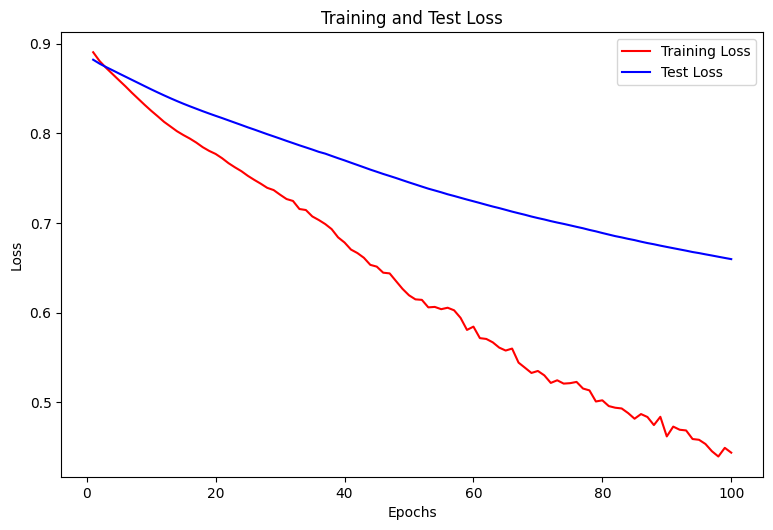

In [31]:
num_class = 4
n_workers = os.cpu_count()
batch_size = 18
lr = 1e-4
epochs = 100
checkpoint = "/kaggle/working/tensorboard"
saved_model = "/kaggle/working/saved_model"

train(num_class, n_workers, batch_size, lr, epochs, checkpoint, saved_model)

## Inference

In [32]:
def pred_show_image_grid(model_pth, device, test_dataset, num_classes, idx, num_imgs):
    # Load model checkpoint
    checkpoint = torch.load(model_pth)
    
    model = UNet(
        spatial_dims=3,
        in_channels=4,
        out_channels=4,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2
    ).to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    images, orig_masks, pred_masks = [], [], []
    
    with torch.no_grad():
        for i in idx:
            ori_img, orig_mask = test_dataset[i]
            # ori_img, orig_mask = test[i]
            img = ori_img

            # Predict mask
            img = img.float().to(device).unsqueeze(0)

            pred_mask = model(img)

            pred_mask = torch.argmax(pred_mask, dim=1)  # Bước chuyển đổi đầu ra thành nhãn
            pred_mask = torch.nn.functional.one_hot(pred_mask, num_classes=num_class)
            pred_mask = pred_mask.permute(0, 4, 1, 2, 3)  # Chuyển đổi để có dạng (B, C, D, H, W)
            
            pred_mask = pred_mask.squeeze(0)
            pred_mask = pred_mask.permute(0, 3, 2, 1)
            pred_mask = pred_mask.cpu().numpy()
            
            images.append(ori_img.permute(0, 3, 2, 1))
            orig_masks.append(orig_mask.permute(0, 3, 2, 1))
            pred_masks.append(pred_mask)
    
    
    # images.extend(orig_masks)
    # images.extend(pred_masks)

    # Kích thước của figure
    fig = plt.figure(figsize=(20, 40))
    
    for idx in range(num_imgs):
        for j in range(4):
            ax = fig.add_subplot(num_imgs * 3, 4, idx * 12 + j + 1)
            ax.imshow(images[idx][j][:, :, 64], cmap='bone')
            ax.axis('off')
            if idx == 0:
                titles = ["T1", "T2", "FLAIR", "T1CE"]
                ax.set_title(titles[j], fontsize=20)
    
            ax1 = fig.add_subplot(num_imgs * 3, 4, idx * 12 + 4 + j + 1)
            ax1.imshow(orig_masks[idx][j][:, :, 64], cmap='bone')
            ax1.axis('off')
    
            ax2 = fig.add_subplot(num_imgs * 3, 4, idx * 12 + 8 + j + 1)
            ax2.imshow(pred_masks[idx][j][:, :, 64], cmap='bone')
            ax2.axis('off')
    
    plt.tight_layout()
    plt.show()


In [33]:
 test_dataset = BratsDataset(is_train=False, transform=val_transforms)



indexs = [4, 14, 24, 34]




/tmp/ipykernel_23/943165843.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_pth)


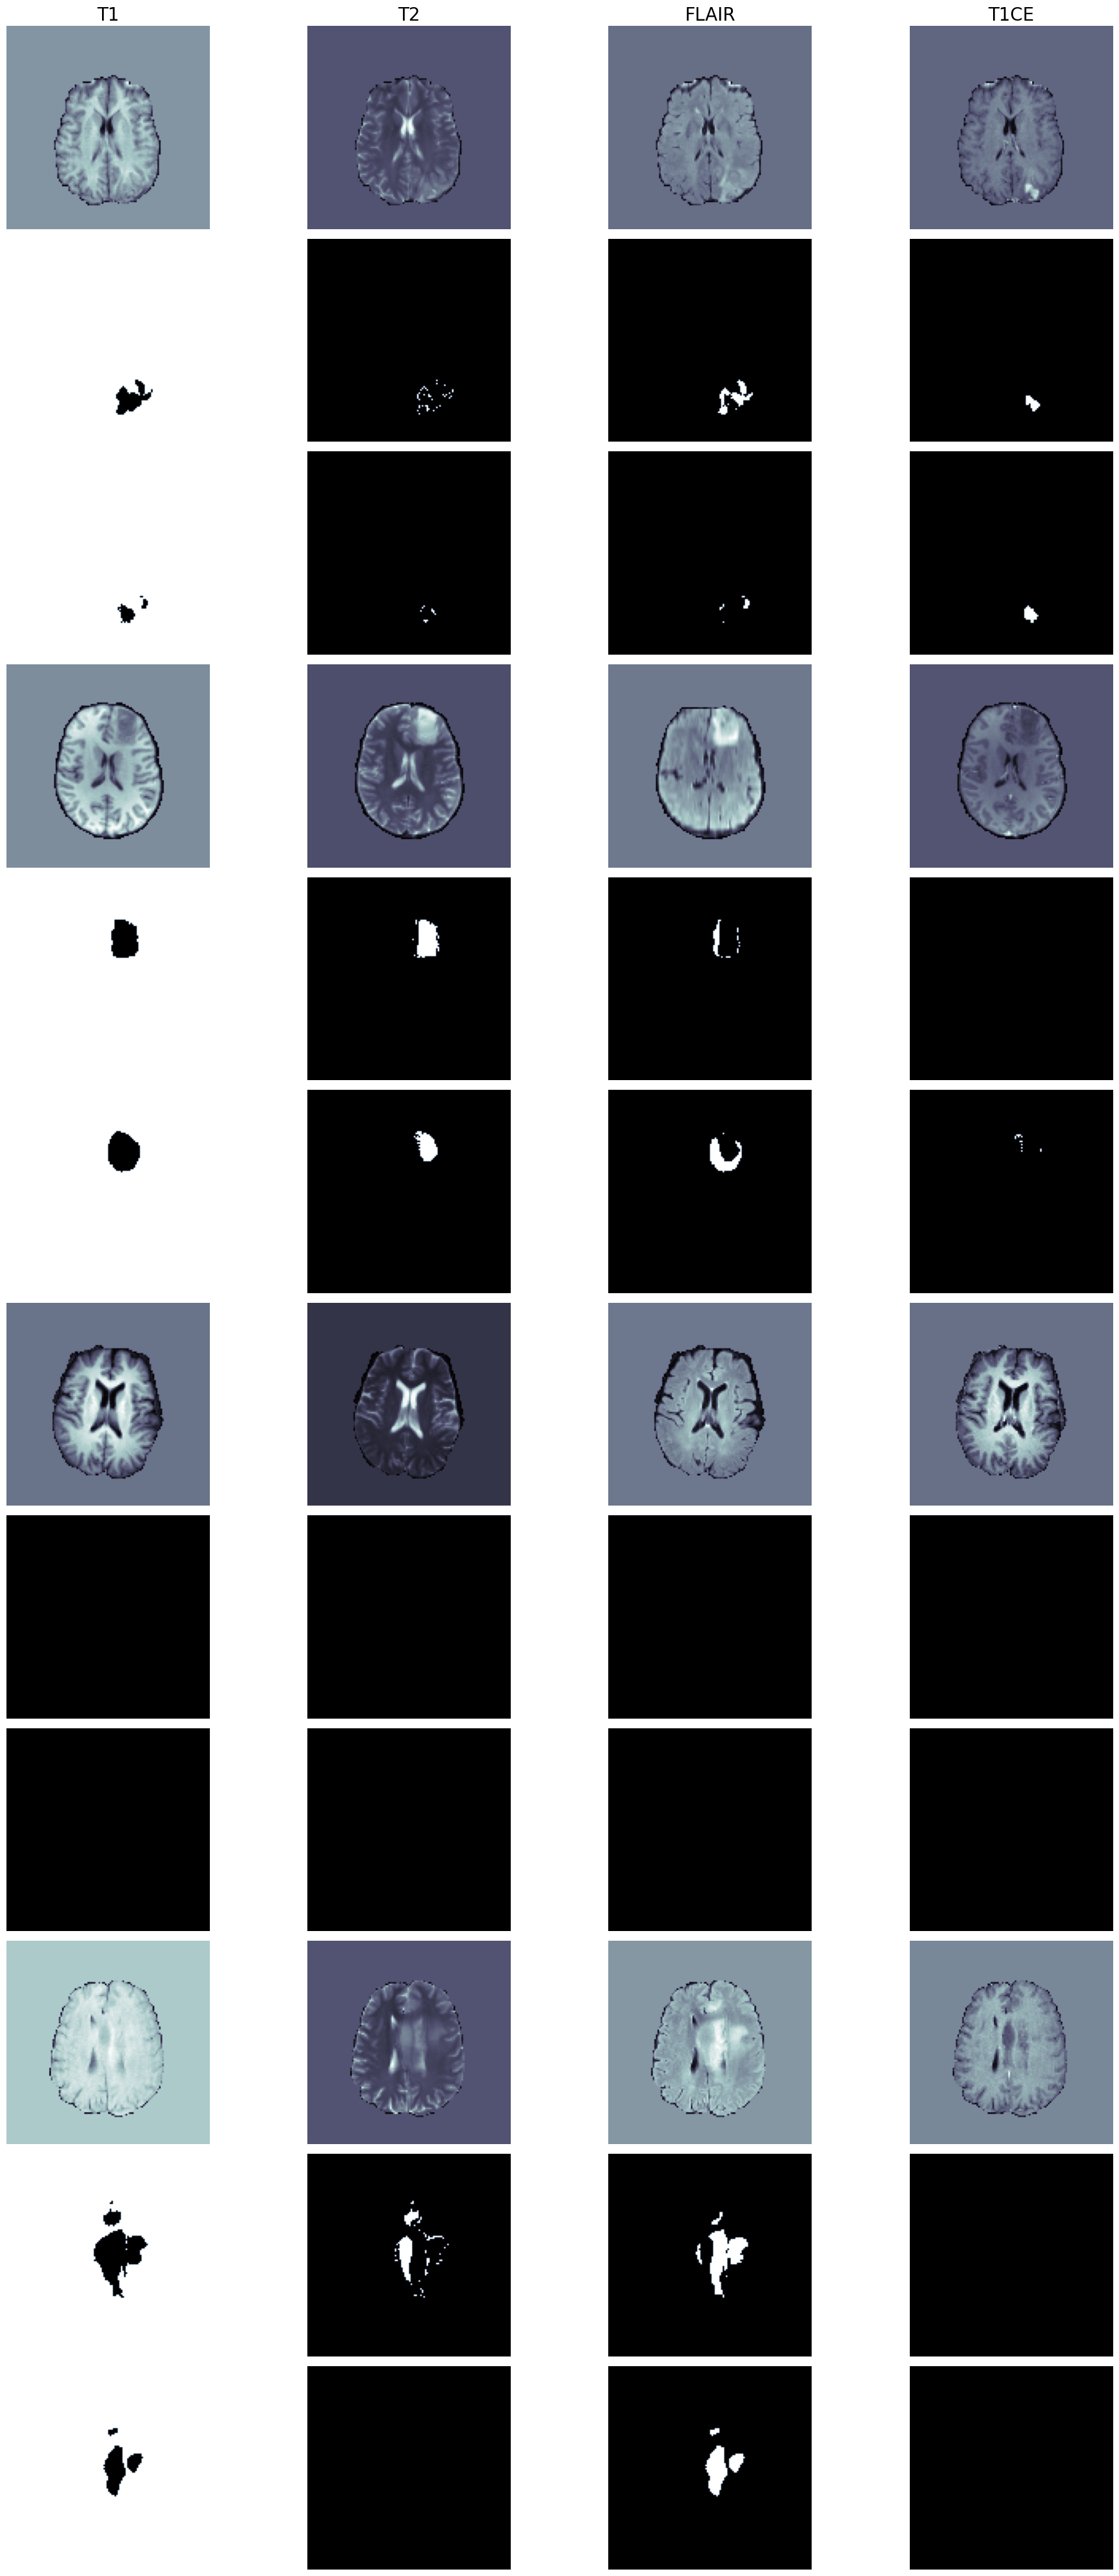

In [34]:
#Note: You must train the model before using this param
model_pth = "/kaggle/working/saved_model/best.pt"
num_classes = 4
device = "cuda" if torch.cuda.is_available() else "cpu" 
print("\n")
indexs = [4, 14, 24, 34]
print("indexs =", indexs)
print("\n")

#Show images
pred_show_image_grid(model_pth, device, test_dataset, num_classes, indexs, num_imgs= 4)